# Reddit Data Collection and Visualization

This notebook is designed to collect comments from a specified subreddit using Reddit's API through PRAW (Python Reddit API Wrapper). It filters out comments based on predefined blacklists and visualizes the data for insights.

## Features:
- Fetch comments from a chosen subreddit and filter ('top', 'hot', 'controversial').
- Exclude comments from blacklisted authors and comments with specific content (e.g., '[deleted]', '[removed]').
- Visualize the collected data for insights.

## Setup and Imports

Before running this notebook, ensure you have installed the necessary Python packages: `praw`, `pandas`, and any others required for your specific environment.


In [1]:
import praw
import pandas as pd
from datetime import datetime
from typing import TypedDict
import matplotlib.pyplot as plt

# PRAW core exceptions
import prawcore
from prawcore.exceptions import Redirect, RequestException

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Configuration

Set the target subreddit, and other configurations here.

In [2]:
# Subreddit configuration
SUBREDDIT_NAME = 'Philippines'
SUBREDDIT_FILTER = 'top'
LIMIT = 11  # Adjust as needed, up to a maximum of 1000 due to Reddit's API limit

# Data filtering criteria
AUTHOR_BLACKLIST = ['AutoModerator']
BODY_BLACKLIST = ['[deleted]', '[removed]']

# Define options for subreddit fetching, mainly the limit
OPTIONS = {
    'limit': LIMIT,
}

# Constants for file naming
CURRENT_DATETIME = datetime.today().strftime("%Y%m%d-%H%M%S")   # Current date and time for filename
FILENAME = f'data-{SUBREDDIT_NAME}-{CURRENT_DATETIME}-{SUBREDDIT_FILTER}.csv'  # Filename format

## DataRow Definition

Define a structure for the data rows to ensure consistent data handling.

In [3]:
class DataRow(TypedDict):
    id: str
    author: str
    body: str
    score: int
    subreddit: str
    timestamp: str
    submission_name: str
    submission_text: str

## Data Collection & Execution

In this section, we will execute the data collection process which involves connecting to the Reddit API through PRAW (Python Reddit API Wrapper), fetching comments from the specified subreddit, and filtering the data based on predefined criteria. The final dataset will then be prepared for analysis and saved to a CSV file for further use.


In [4]:
if __name__ == "__main__":
    # Initialize PRAW Reddit instance with credentials & user agent
    reddit = praw.Reddit(
        client_id="YJvLI6W6NMduk55T10M6Qw",
        client_secret="RP9c8mfnX2OGF2t6aHQKHhvxLV4UUg",
        user_agent="linux:praw:v7.7.2 (by u/Elairion)",
        ratelimit_seconds=6000, # Give heavy allowance for rate limits to avoid TooManyRequests error
    )

    data_collection: list[DataRow] = [] # List to hold all DataRow items

    # Get subreddit instance from PRAW
    subreddit_instance = reddit.subreddit(SUBREDDIT_NAME)

    # Select the subreddit section based on the filter argument (top, controversial, hot)
    result = {
        'top': subreddit_instance.top(**OPTIONS),
        'controversial': subreddit_instance.controversial(**OPTIONS),
        'hot': subreddit_instance.hot(**OPTIONS),
    }[SUBREDDIT_FILTER]

    progress = 0    # Track the number of processed posts

    try:
        for submission in result:   # Iterate through submissions in the selected subreddit section
            progress += 1
            print(f"POST: {progress} / {LIMIT}")

            submission.comments.replace_more(limit=None)    # Load all comments by replacing "MoreComments"
            comments = submission.comments.list()   # Flatten the comment tree into a list

            comments_progress = 0   # Track the number of processed comments
            comments_num = len(comments)    # Total number of comments for the current submission

            for comment in comments:    # Iterate through each comment
                comments_progress += 1
                print(f"COMMENTS: {comments_progress} / {comments_num}")    # Log comment processing progress

                # Get author name, or set as empty string if not available
                author = (
                    comment.author.name 
                    if isinstance(comment.author, praw.models.Redditor) 
                    else ''
                )
                body = comment.body # Comment text

                # Skip comment if the author is in the blacklist
                if author in AUTHOR_BLACKLIST: continue

                # Skip comment if body is in the blacklist
                if body in BODY_BLACKLIST: continue

                data_row: DataRow = {
                    'id': comment.id,
                    'subreddit': comment.subreddit.display_name,
                    'submission_name': submission.title,
                    'submission_text': submission.selftext,
                    'author': author,
                    'body': body,
                    'score': comment.score,
                    'timestamp': datetime.utcfromtimestamp(
                        comment.created_utc
                    ).strftime('%Y-%m-%d %H:%M:%S'),
                }
                data_collection.append(data_row)    # Add the data row to the collection
    except prawcore.exceptions.TooManyRequests:
        pass    # Handle rate limit exceptions gracefully
    except Redirect:
        print("ERROR: Request redirected. Please check subreddit name and try again")
        exit(1)
    except RequestException:
        print("ERROR: Request exception. Please check subreddit name and try again")
        exit(1)

    # Convert the list of DataRow dictionaries to a Pandas DataFrame
    data_frame = pd.DataFrame(data_collection)

    data_frame.to_csv(FILENAME) # Save the DataFrame to a CSV file

    print("Saved data") # Log completion



POST: 1 / 11
COMMENTS: 1 / 574
COMMENTS: 2 / 574
COMMENTS: 3 / 574
COMMENTS: 4 / 574
COMMENTS: 5 / 574
COMMENTS: 6 / 574
COMMENTS: 7 / 574
COMMENTS: 8 / 574
COMMENTS: 9 / 574
COMMENTS: 10 / 574
COMMENTS: 11 / 574
COMMENTS: 12 / 574
COMMENTS: 13 / 574
COMMENTS: 14 / 574
COMMENTS: 15 / 574
COMMENTS: 16 / 574
COMMENTS: 17 / 574
COMMENTS: 18 / 574
COMMENTS: 19 / 574
COMMENTS: 20 / 574
COMMENTS: 21 / 574
COMMENTS: 22 / 574
COMMENTS: 23 / 574
COMMENTS: 24 / 574
COMMENTS: 25 / 574
COMMENTS: 26 / 574
COMMENTS: 27 / 574
COMMENTS: 28 / 574
COMMENTS: 29 / 574
COMMENTS: 30 / 574
COMMENTS: 31 / 574
COMMENTS: 32 / 574
COMMENTS: 33 / 574
COMMENTS: 34 / 574
COMMENTS: 35 / 574
COMMENTS: 36 / 574
COMMENTS: 37 / 574
COMMENTS: 38 / 574
COMMENTS: 39 / 574
COMMENTS: 40 / 574
COMMENTS: 41 / 574
COMMENTS: 42 / 574
COMMENTS: 43 / 574
COMMENTS: 44 / 574
COMMENTS: 45 / 574
COMMENTS: 46 / 574
COMMENTS: 47 / 574
COMMENTS: 48 / 574
COMMENTS: 49 / 574
COMMENTS: 50 / 574
COMMENTS: 51 / 574
COMMENTS: 52 / 574
COMMENTS

/var/folders/3b/xf9plq8j5v7dyfzmhrd2kcf80000gn/T/ipykernel_76493/412251424.py:61: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  'timestamp': datetime.utcfromtimestamp(


COMMENTS: 1 / 1114
COMMENTS: 2 / 1114
COMMENTS: 3 / 1114
COMMENTS: 4 / 1114
COMMENTS: 5 / 1114
COMMENTS: 6 / 1114
COMMENTS: 7 / 1114
COMMENTS: 8 / 1114
COMMENTS: 9 / 1114
COMMENTS: 10 / 1114
COMMENTS: 11 / 1114
COMMENTS: 12 / 1114
COMMENTS: 13 / 1114
COMMENTS: 14 / 1114
COMMENTS: 15 / 1114
COMMENTS: 16 / 1114
COMMENTS: 17 / 1114
COMMENTS: 18 / 1114
COMMENTS: 19 / 1114
COMMENTS: 20 / 1114
COMMENTS: 21 / 1114
COMMENTS: 22 / 1114
COMMENTS: 23 / 1114
COMMENTS: 24 / 1114
COMMENTS: 25 / 1114
COMMENTS: 26 / 1114
COMMENTS: 27 / 1114
COMMENTS: 28 / 1114
COMMENTS: 29 / 1114
COMMENTS: 30 / 1114
COMMENTS: 31 / 1114
COMMENTS: 32 / 1114
COMMENTS: 33 / 1114
COMMENTS: 34 / 1114
COMMENTS: 35 / 1114
COMMENTS: 36 / 1114
COMMENTS: 37 / 1114
COMMENTS: 38 / 1114
COMMENTS: 39 / 1114
COMMENTS: 40 / 1114
COMMENTS: 41 / 1114
COMMENTS: 42 / 1114
COMMENTS: 43 / 1114
COMMENTS: 44 / 1114
COMMENTS: 45 / 1114
COMMENTS: 46 / 1114
COMMENTS: 47 / 1114
COMMENTS: 48 / 1114
COMMENTS: 49 / 1114
COMMENTS: 50 / 1114
COMMENTS:

## Data Visualization

Visualize the collected data to gain insights, such as the number of comments per post.

In [5]:
# Show the table

data_frame.head()


,id,subreddit,submission_name,submission_text,author,body,score,timestamp
0,j35qbnp,Philippines,David Bautista Covered Manny Pacquiao Tattoo A...,,YunaKinoshita,"Yup! I remember this, Batista was part of Pacq...",600,2023-01-06 05:26:01
1,j35kuyt,Philippines,David Bautista Covered Manny Pacquiao Tattoo A...,,yuuri_ni_victor,Nakakahiya mindset ng mga pinoy. Ang tagal na ...,926,2023-01-06 04:35:23
2,j35mkqs,Philippines,David Bautista Covered Manny Pacquiao Tattoo A...,,mistersleenkee,Before kyrie lost nike and kanye lost adidas.....,198,2023-01-06 04:50:34
3,j35gnl0,Philippines,David Bautista Covered Manny Pacquiao Tattoo A...,,Teduary,Tama behavior.,1715,2023-01-06 04:01:11
4,j35okis,Philippines,David Bautista Covered Manny Pacquiao Tattoo A...,,wiredfractal,Just saw the video sa YouTube yesterday when h...,107,2023-01-06 05:09:32


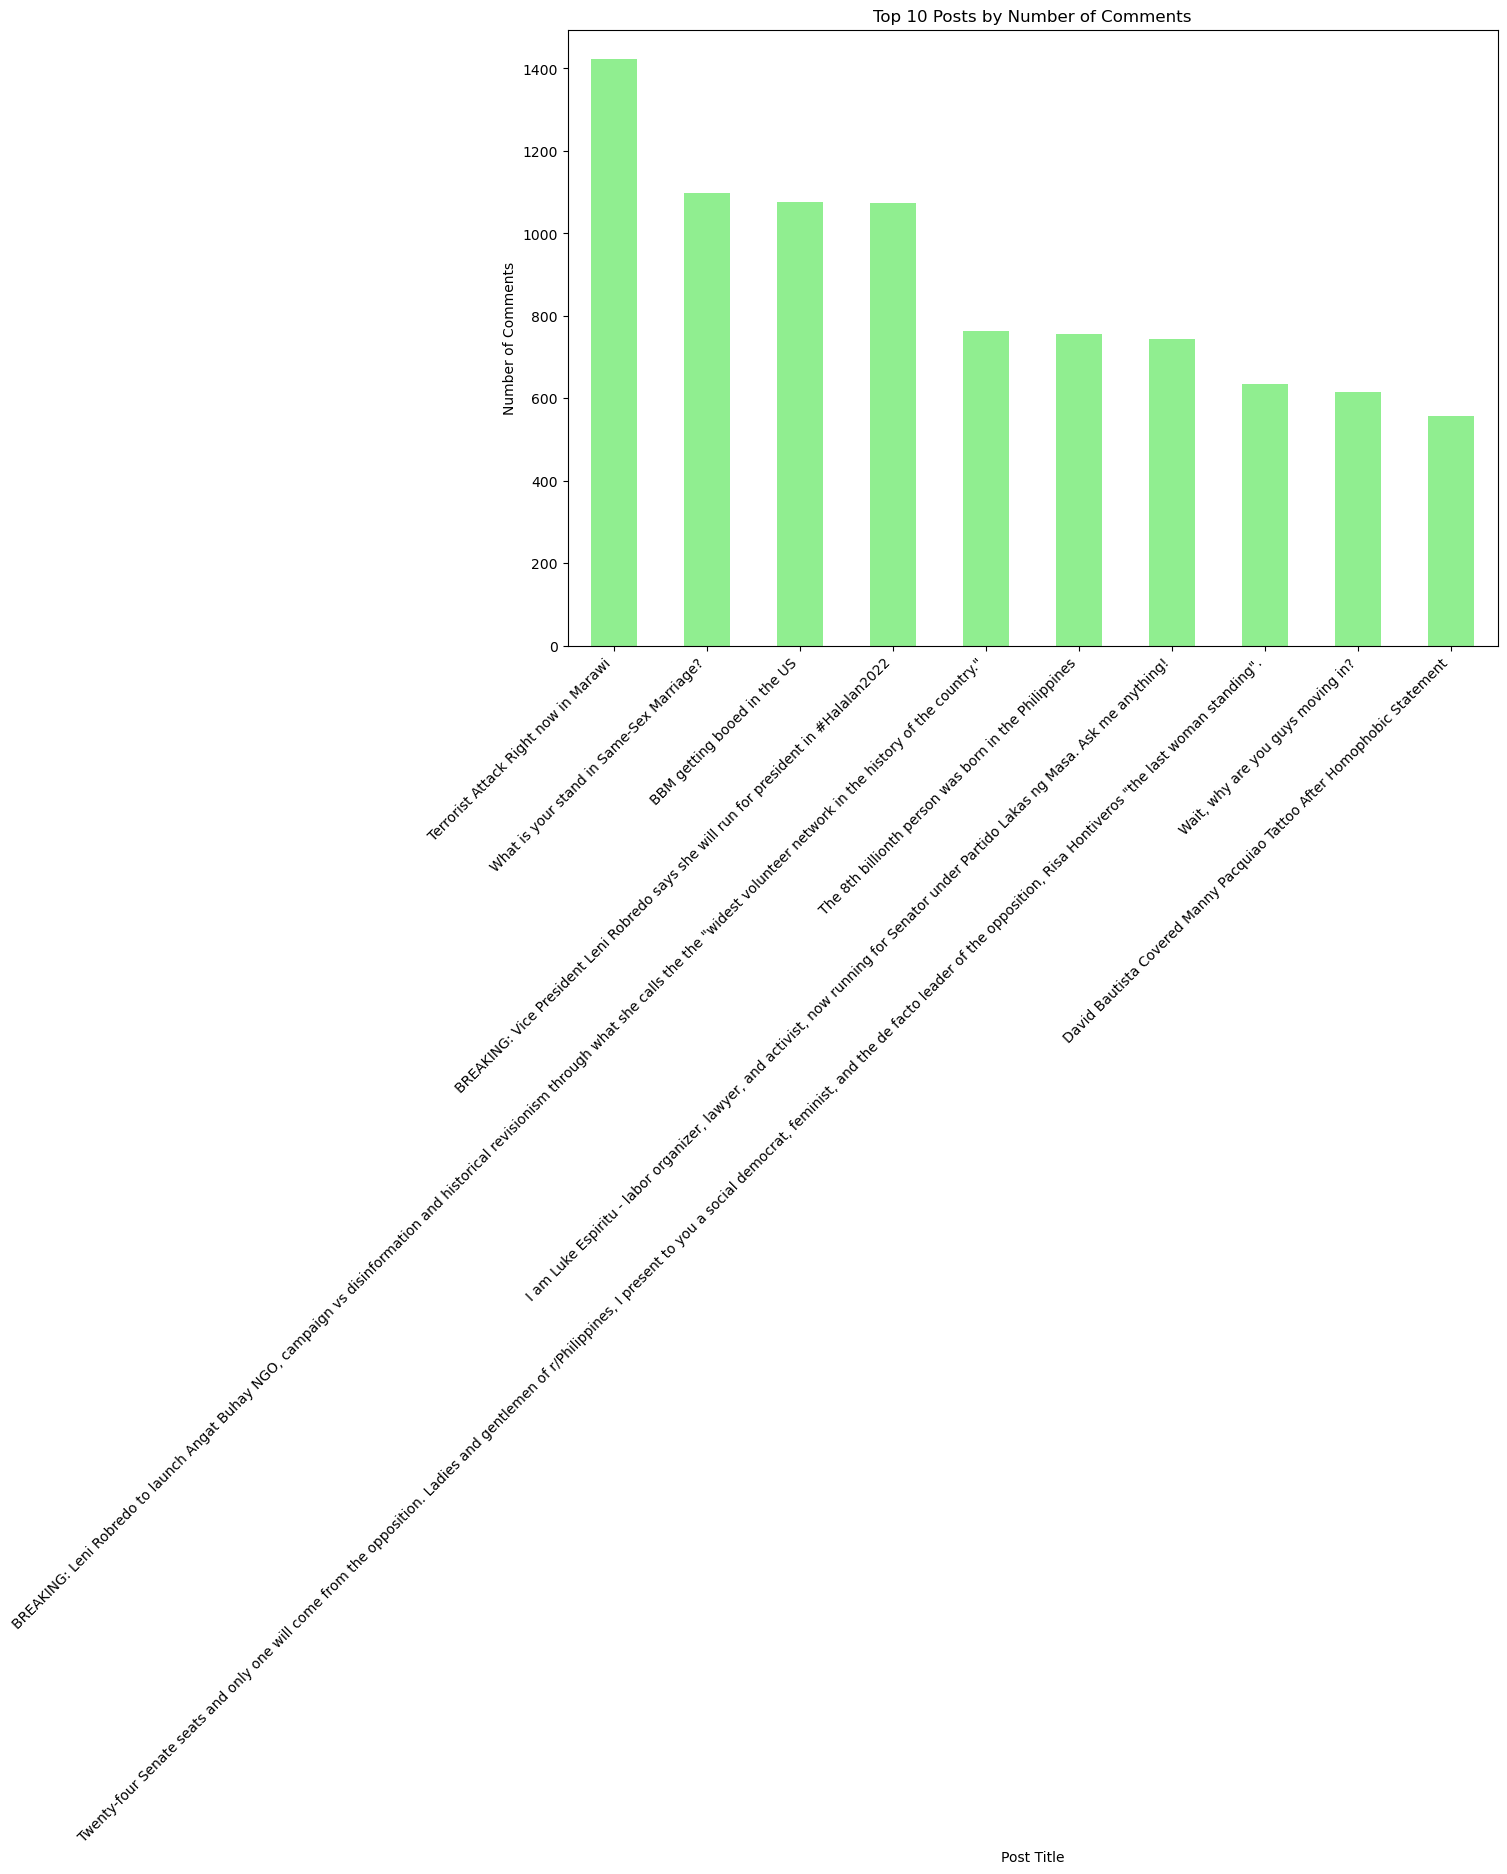

In [6]:
# Group the data by submission_name and count the number of comments for each post
comments_per_post = data_frame.groupby('submission_name')['id'].count()

# Sorting the counts and selecting the top N posts for better visibility in the bar chart
top_comments_per_post = comments_per_post.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
top_comments_per_post.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Posts by Number of Comments')
plt.xlabel('Post Title')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45, ha='right')  # Rotate post titles for better readability
plt.show()

In [7]:
# Group the data by 'submission_name' and count the number of comments for each post
comments_per_post = data_frame.groupby('submission_name')['id'].count().sort_values(ascending=False)

# Convert the Series object to DataFrame for better readability
comments_per_post_df = comments_per_post.to_frame(name='Number of Comments')

# Resetting the index to have 'submission_name' as a column instead of an index
comments_per_post_df.reset_index(inplace=True)

# Optionally, rename the columns for better readability
comments_per_post_df.columns = ['Post Title', 'Number of Comments']

# Display the DataFrame
comments_per_post_df

,Post Title,Number of Comments
0,Terrorist Attack Right now in Marawi,1423
1,What is your stand in Same-Sex Marriage?,1097
2,BBM getting booed in the US,1077
3,BREAKING: Vice President Leni Robredo says she...,1073
4,BREAKING: Leni Robredo to launch Angat Buhay N...,763
5,The 8th billionth person was born in the Phili...,756
6,"I am Luke Espiritu - labor organizer, lawyer, ...",743
7,Twenty-four Senate seats and only one will com...,634
8,"Wait, why are you guys moving in?",615
9,David Bautista Covered Manny Pacquiao Tattoo A...,556
